In [1]:
#import dill   
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm, trange

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print('GPU available? {}'.format(torch.cuda.is_available()))

GPU available? False


In [3]:
def toy_function(N):
    
    noise_std = 0.02
    eps_train = noise_std*np.random.randn(N,)
    eps_test =  noise_std*np.random.randn(int(N*0.5),)
    
    
    x_train = np.linspace(0, 0.5, N, endpoint=True, dtype =np.float32)
    x_test =  np.linspace(-1, 1, int(N*0.5), endpoint=True, dtype =np.float32)
    
    y_train = x_train + 0.3*np.sin(2*np.pi*(x_train + eps_train)) + 0.3*np.sin(4*np.pi*(x_train + eps_train)) + eps_train
    y_test =  x_test + 0.3*np.sin(2*np.pi*(x_test + eps_test)) + 0.3*np.sin(4*np.pi*(x_test + eps_test)) + eps_test
    
    x_train = np.atleast_2d(x_train).T
    x_test = np.atleast_2d(x_test).T
    
    x_train_tensor = torch.Tensor(x_train)
    y_train_tensor = torch.Tensor(y_train)
    x_test_tensor =  torch.Tensor(x_test)
    y_test_tensor =  torch.Tensor(y_test)
    
    plt.plot(x_train, y_train, 'rs', label='train')
    plt.plot(x_test, y_test, 'k.', label='test')
    plt.legend()
    plt.show()

    return x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor

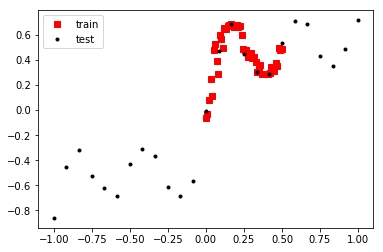

In [4]:
x_train, y_train, x_test, y_test = toy_function(50)

/Users/goncalves1/local/anaconda3/envs/nci_pilot3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/Users/goncalves1/local/anaconda3/envs/nci_pilot3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100%|██████████| 20000/20000 [01:45<00:00, 190.30it/s]


Finished Training


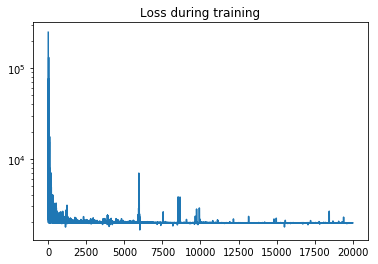

In [22]:
from BBB import MLP_BBB

layers_units = [10, 10]
layers_activ = ['relu', 'tanh']
assert len(layers_units) == len(layers_activ)

net = MLP_BBB(1, 1, layers_units, layers_activ,
              noise_tol=0.02, prior_std=10)

net.to(DEVICE)
net.train()

data = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
target = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=1e-1) #, weight_decay=1e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

epochs = 20000
milestones = [0.3, 0.5, 0.7, 0.8, 0.9]
milestones = [int(m*epochs) for m in milestones]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

loss_arr = list()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    
#     print('Epoch:', epoch,'LR:', scheduler.get_lr())
    
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = net.sample_elbo(data, target, 1)
    loss.backward()
    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.item())

print('Finished Training')

plt.plot(loss_arr)
plt.yscale('log')
plt.title('Loss during training')
plt.show()

/Users/goncalves1/local/anaconda3/envs/nci_pilot3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Users/goncalves1/local/anaconda3/envs/nci_pilot3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


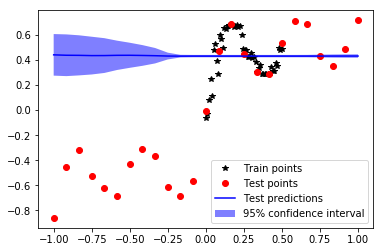

In [24]:
n_post_samples = 100
post_dist = np.zeros((len(x_test), n_post_samples + 1)) 

data_ts = torch.tensor(x_test, dtype=torch.float32)
target_ts = torch.tensor(y_test, dtype=torch.float32)

net.eval()
with torch.no_grad():
    for j in range(n_post_samples): 
        post_dist[:, j] = net(data_ts).detach().numpy().ravel()
    post_dist[:, n_post_samples] = net(data_ts).detach().numpy().ravel()

y_mean = post_dist.mean(axis=1)
sigma = post_dist.std(axis=1)

plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Train points')
plt.plot(x_test.numpy(), y_test.numpy(), 'ro', label='Test points')
plt.plot(x_test.numpy(), y_mean, 'b-', label='Test predictions')
plt.fill(np.concatenate([x_test.numpy(), x_test.numpy()[::-1]]),
         np.concatenate([y_mean - 1.9600 * sigma,
                        (y_mean + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()
plt.show()